In [9]:
import os,sys
import json
import torch

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

In [10]:
# 构建数据集
from torch.utils.data import DataLoader,Subset
from src.dataset import build_global_vocab_and_maxcount, CLEVRMultiLabelByImage
import torchvision.transforms as T


clevr_root = "../CLEVR_v1.0"

# 全局统计：colors/shapes/max_objects（train+val+test）
colors, shapes, max_objects, _ = build_global_vocab_and_maxcount(clevr_root, splits=("train","val"))

print("num_colors:", len(colors), colors)
print("num_shapes:", len(shapes), shapes)
print("max_objects:", max_objects)

tfm64 = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
])


train_ds_64 = CLEVRMultiLabelByImage(
    clevr_root=clevr_root,
    split="train",
    colors=colors,
    shapes=shapes,
    max_objects=max_objects,
    transform=tfm64
)

train_dl_64 = DataLoader(train_ds_64, batch_size=100, shuffle=True, num_workers=0)

num_colors: 8 ['blue', 'brown', 'cyan', 'gray', 'green', 'purple', 'red', 'yellow']
num_shapes: 3 ['cube', 'cylinder', 'sphere']
max_objects: 10


In [11]:
# 构建模型
from src.model import TDVAE

tdvae = TDVAE()


In [12]:
from src.train import TrainCfg, fit_tdvae, evaluate
import torch.optim as optim

cfg = TrainCfg(
    epochs=50,
    lr=1e-3,
    weight_decay = 0,
    recon_type="bce_logits",   # 你已确认 images 在 [0,1] bce_logits\mse\l1
    use_amp=False,
    log_every=700,
    save_best=False,
    ckpt_dir="../checkpoints",
    ckpt_name="tdvae_v64.pt",
    device="cuda" if torch.cuda.is_available() else "cpu",
)

optimizer = optim.Adam(tdvae.parameters(), lr=cfg.lr)

# 若你还没做 val_dl，可以先 val_loader=None
result = fit_tdvae(tdvae, train_dl_64, val_dl=None, optimizer=optimizer, cfg = cfg)


loss: 8389.3295 | rec: 8385.3264 | kl_y: 1.0646 | kl_z: 2.9385 | mse: 0.0052 | bce: 0.6824
loss: 8369.2837 | rec: 8360.8143 | kl_y: 1.4453 | kl_z: 7.0240 | mse: 0.0043 | bce: 0.6804
loss: 8361.7885 | rec: 8350.8059 | kl_y: 1.4736 | kl_z: 9.5089 | mse: 0.0039 | bce: 0.6796
loss: 8358.1715 | rec: 8346.0013 | kl_y: 1.4873 | kl_z: 10.6829 | mse: 0.0037 | bce: 0.6792
loss: 8355.6034 | rec: 8341.9464 | kl_y: 1.4245 | kl_z: 12.2325 | mse: 0.0036 | bce: 0.6789
loss: 8353.4478 | rec: 8338.8487 | kl_y: 1.3568 | kl_z: 13.2423 | mse: 0.0034 | bce: 0.6786
loss: 8351.9455 | rec: 8336.7999 | kl_y: 1.3107 | kl_z: 13.8349 | mse: 0.0034 | bce: 0.6785
loss: 8350.7416 | rec: 8335.1455 | kl_y: 1.2325 | kl_z: 14.3637 | mse: 0.0033 | bce: 0.6783
loss: 8349.9083 | rec: 8334.0396 | kl_y: 1.1352 | kl_z: 14.7334 | mse: 0.0033 | bce: 0.6782
loss: 8349.3549 | rec: 8333.2801 | kl_y: 1.0187 | kl_z: 15.0561 | mse: 0.0032 | bce: 0.6782
loss: 8348.9522 | rec: 8332.7515 | kl_y: 0.9430 | kl_z: 15.2578 | mse: 0.0032 | bce

In [13]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt_path = "../checkpoints/tdvae_v64.pt"  # 你的实际路径
tdvae = TDVAE().to(device)

ckpt = torch.load(ckpt_path, map_location=device)

# 如果你保存的是 {"model": state_dict, ...}
if isinstance(ckpt, dict) and "model" in ckpt:
    tdvae.load_state_dict(ckpt["model"])
else:
    # 如果你保存的就是纯 state_dict
    tdvae.load_state_dict(ckpt)

tdvae.eval()
print("Loaded checkpoint from:", ckpt_path)


Loaded checkpoint from: ../checkpoints/tdvae_v64.pt


C:\Users\cyh\AppData\Local\Temp\ipykernel_7844\627846492.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


In [14]:
# 取第 i 张（你可以换 i）
i = 1100
image, color_mh, shape_mh, count_oh, img_fn = train_ds_64[i]

print("file:", img_fn)
print("gt count:", int(count_oh.argmax()))


file: CLEVR_train_001100.png
gt count: 10


In [15]:
import torch.nn.functional as F

def decode_multihot(mh, names, thr=0.5):
    """mh: (K,) in {0,1} or prob; names: list[str] length K"""
    idx = (mh >= thr).nonzero(as_tuple=True)[0].tolist()
    return [names[j] for j in idx]

with torch.no_grad():
    x = image.unsqueeze(0).to(device)  # (1,3,224,224)

    out = tdvae(x)
    if isinstance(out, (tuple, list)) and len(out) == 3:
        x_logits, post, heads = out
    else:
        # 如果你 forward 返回 dict
        x_logits= out["x_logits"]

    p = torch.sigmoid(x_logits)
    print("pred mean:", p.mean().item(), "pred max:", p.max().item(), "pred min:", p.min().item())
    print("gt mean:", image.mean().item(), "gt max:", image.max().item(), "gt min:", image.min().item())
    # --- 预测 ---
    # color_prob = torch.sigmoid(heads["color_logits"])[0].detach().cpu()  # (8,)
    # shape_prob = torch.sigmoid(heads["shape_logits"])[0].detach().cpu()  # (3,)
    # count_pred = heads["count_logits"].argmax(dim=1)[0].item()           # int 0..10

    # --- 重建 ---
    recon = torch.sigmoid(x_logits)[0].detach().cpu()  # (3,224,224) in [0,1]

# print("Pred count:", count_pred)
# print("Pred colors:", decode_multihot(color_prob, colors, thr=0.5))
# print("Pred shapes:", decode_multihot(shape_prob, shapes, thr=0.5))

# gt_colors = decode_multihot(color_mh, colors, thr=0.5)
# gt_shapes = decode_multihot(shape_mh, shapes, thr=0.5)
# gt_count  = int(count_oh.argmax())

# print("GT count:", gt_count)
# print("GT colors:", gt_colors)
# print("GT shapes:", gt_shapes)

pred mean: 0.44491466879844666 pred max: 0.6377995610237122 pred min: 0.12326544523239136
gt mean: 0.4487933814525604 gt max: 0.6509804129600525 gt min: 0.019607843831181526


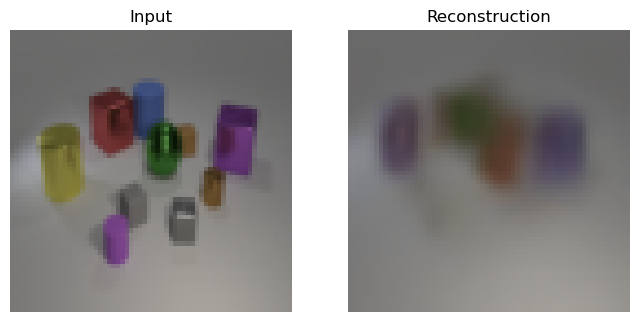

In [16]:
import matplotlib.pyplot as plt

def show_img(t):
    # t: (3,H,W) in [0,1]
    t = t.permute(1,2,0).numpy()
    plt.imshow(t)
    plt.axis("off")

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Input")
show_img(image)          # dataset 给的 image 通常已是 [0,1]

plt.subplot(1,2,2)
plt.title("Reconstruction")
show_img(recon)

plt.show()
